# Diffusion map

#### Author: Ching-Ru Chung, 2019

## Abstract

When we use computer do group clustering, an algorithm called k-means clustering is a good choice for us. But this algorithm has a defect that it can't make a good result when the points have complex distribution in data. This semester I saw my senior's Python code about diffusion map and I conver it into Julia. It transform the points with complex form into one with simpler form, which can be treat well by using k-means clustering. In the following, I will show how to construct a diffusion map step by step and implement my code.

## Framework

Given a data set $X=\{x_1,...,x_n\} \in \mathbb{R}^d$, construct the diffusion maps by using following steps:

### 1. Define a kernel matrix

Let $K$ be a kernel matrix with entries $ K_{ij}=k(x_{i},x_{j}) $, where $k$ is the Guassian kernel
$$ k(x,y) = \exp(-\frac{\lVert x-y \rVert^2}{4\sigma}), $$
and $\sigma$ is a manually picked constant.  

In [1]:
function get_K(X , sigma)
    sigma *= 4 ;
    n = size(X,1) ; # number of points
    d = size(X,2) ; # dimension of points
    K = ones(n,n) ; # the diagonal entries are 1
    
    # get components of kernel matrix
    for ii = 1 : n
        for jj = ii+1 : n
            temp = sum((X[ii,1:d] - X[jj,1:d]).^2) ;
            K[ii,jj] = exp(-temp/sigma) ;
            K[jj,ii] = K[ii,jj] ; # since k(x,y) = k(y,x)
        end
    end
    
    return K ;
end

get_K (generic function with 1 method)

### 2. Construct a matrix $Q$ that related to diffusion matrix

Diffusion matrix is a matrix that describe the connectivity between two data points, which can be consider as the probability of jumping from one point to another in one step of random walk. Consider a matrix $Q$, with it's entries $$ Q_{ij}=\frac{K_{ij}}{\sqrt{\sum_{j=1}^n K_{ij}} \sqrt{\sum_{i=1}^n K_{ij}}} $$

In [2]:
function get_Q(K)
    
    n = size(K,1) ;
    Q = zeros(n,n) ;
    temp1 = zeros(n) ;
    temp2 = zeros(n) ;
    
    # get denominators of Q_i and Q_j
    for ii = 1 : n
        temp1[ii] = sqrt(sum(K[ii,:])) ;
        temp2[ii] = sqrt(sum(K[:,ii])) ;
    end
    
    # get components of Q
    for ii = 1 : n
        for jj = 1 : n
            Q[ii,jj] = K[ii,jj]/(temp1[ii]*temp2[jj]) ;
        end
    end
    
    return Q ;
end

get_Q (generic function with 1 method)

### 3. Find eigenvectors and eigenvalues of the diffusion matrix

The eigenvalues of $Y$ is equal to the eigenvalues of $Q$, which is arrange in descending power.  
The right and left eigenvectors of $P$ are $$ \psi_k=e_k * e_1 $$ $$\phi_k=e_k / e_1 $$
respectively, where $e_k$ is the eigenvector corresponding to the k-th eigenvalue of $Q$,
$e_1$ is the eigenvector of the first eigenvalue of $Q$.  
<font color = Red>The multiplication and division is applied to each element, not the matrix operations.</font>  
Dimensional reduction is done by neglecting certain dimensions in the diffusion space, since the orthogonal left eigenvectors of $Y$ form a basis for the diffusion space, and the order of eigenvalue is associated to the importance of relation on the data.

In [3]:
using LinearAlgebra

function get_eig(Q , c)
    
    n = size(Q , 1) ;
    
    U,S,V = svd(Q) ; # U and S contains eigenvectors and eigenvalues repectively 
                     # which is arranged in descending power. 
    
    # find psi and phi
    psi = zeros(n,c) ;
    phi = zeros(n,c) ;
    
    # neglect those behind c-th eigenvalue since the order of eigenvalue 
    # is associated to the importance of relation on the data.
    for ii = 1 : c
        psi[: , ii] = U[:,ii+1] .* U[:,1] ;
        phi[: , ii] = U[:,ii+1] ./ U[:,1] ;
    end
    
    return psi , phi , S ;
end

get_eig (generic function with 1 method)

### 4. Define a diffusion map 

Let $Y$ be a diffusion map, which map corrdinates between data and diffusion space , with its column
$$ Y_i=[\lambda_i \psi_i] $$
The right eigenvectors $\psi_i$ can be replace as left eigenvectors $\phi_i$.

In [4]:
function get_Y(psi ,  qval , c)
    
    n = size(psi,1) ;
    Y = zeros(n,c) ;
    
    # get components of diffusion map Y
    for ii = 1 : c
        Y[:,ii] = psi[:,ii] .* qval[ii] ;
    end
    
    return Y ;
end

get_Y (generic function with 1 method)

### 5. K-means Clustering

Using k-means method to get the labeling of the datas, here k is a manually select number of groups.

In [5]:
function k_means(Y , cluster) # cluster is the number of groups
    
    n = size(Y,1) ;
    d = size(Y,2) ;
    center = zeros(cluster,d) ;
    index = rand(1:n , cluster) ; # choose three numbers from 1~n randomly
    
    group1 , weight1 = classify(Y , Y[index , :]) ; # the previous one
    center = update_center(Y , group1 , cluster) ;  # update the center
    group2 , weight2 = classify(Y , center) ;       # the last one
    
    # classify and update repeatly until the weight becomes stabilize.
    time = 1 ;
    while abs.((weight2 - weight1)/weight2) > 0.01
        
        # replace as previos one
        group1  = group2 ;
        weight1 = weight2 ;
        
        # update and classify to get a new groups
        center  = update_center(Y , group1 , cluster) ;
        group2 , weight2 = classify(Y , center) ;
        
        time += 1 ;
    end
    
    print("The update times = ", time) ; # print the number of executions of while loop.
    
    return group2
end

k_means (generic function with 1 method)

classify function is to classify the points into three groups by comparing the distances between the point and three centers respectively.

In [6]:
function classify(Y , center)
    
    n = size(Y,1) ;
    cluster = size(center,1) ; # number of center
    weight = 0 ;
    group = ones(n) ; # Classify the points by label as 1 ~ cluster.
    
    for ii = 1 : n
        
        # For all points in Y , find the minimum of distances with centers.
        DistanceMin = sum((Y[ii,:] - center[1,:]).^2) ;
        for jj = 2 : cluster
            
            distance = sum((Y[ii,:] - center[jj,:]).^2) ;
            
            # If the point is closer to one center than the others ,then it will be put in the group belong to the center.
            if DistanceMin > distance
                DistanceMin = distance ;
                group[ii] = jj ;
            end
            
        end
        
        # get weight by summing up all distance between point and center in same group.
        weight += DistanceMin ;
        
    end
    
    return group , weight ;
end

classify (generic function with 1 method)

update_center function is to reset the centers by finding the centroids from each group.

In [7]:
function update_center(Y , group , cluster)
    
    n = size(Y,1) ;
    d = size(Y,2) ;
    center = zeros(cluster,d) ;
    
    # find new centroids (or geometric center) from each group.
    for ii = 1 : n
        center[Int(group[ii]) , :] += Y[ii,:] ;
    end
    center ./= n ;
    
    return center
end

update_center (generic function with 1 method)

## Implementation

### 1. Load data

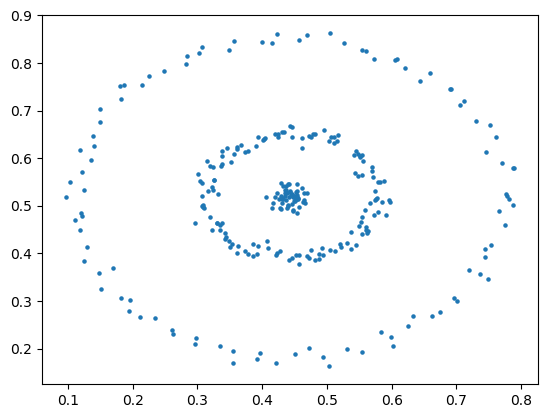

PyObject <matplotlib.collections.PathCollection object at 0x14100aeb8>

In [8]:
using MAT
using PyPlot
file = matread("Data.mat")
X = file["data"] ;
scatter(X[:,1] , X[:,2] , s = 5)

### 2. Construct diffusion map

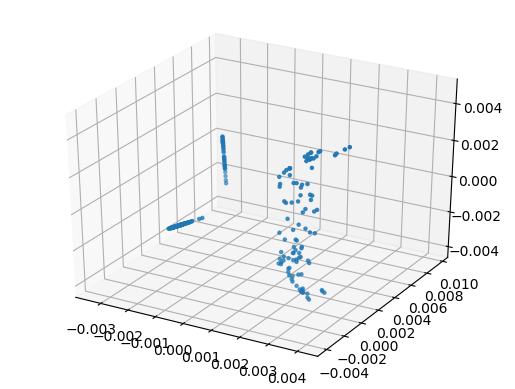

PyObject <mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x14c6785f8>

In [9]:
sigma = 0.00025 ;
c = 3 ; # the number of eigrnvalues we use

# construct diffusion map step by step according to the framework mentioned above.
K = get_K(X ,sigma) ;
Q = get_Q(K) ;
psi , phi , qval = get_eig(Q , c) ;
Y = get_Y(psi ,  qval , c) ;

# print diffution map
scatter3D(Y[:,1] , Y[:,2] , Y[:,3] , s = 5)

### 3. Use k-means clustering

In [10]:
# it will return the label of points and tell us how many times the center was updated.
cluster = 3 ; # seperate into three groups
group = k_means(Y , cluster) ;

The update times = 2

### 4. Show the result

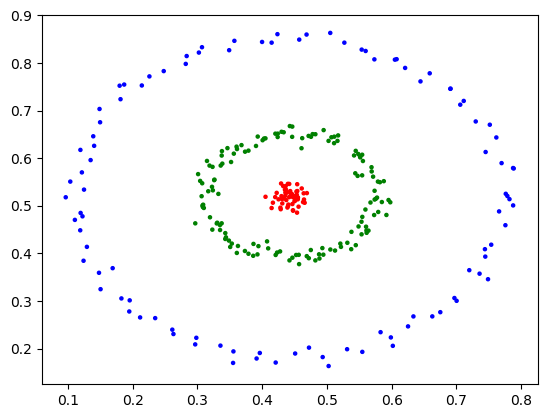

PyObject <matplotlib.collections.PathCollection object at 0x131e17748>

In [11]:
# select the color
dict = Dict(1 => "red" , 2 => "green" , 3 => "blue" , 4 => "black" , 5 => "brown" , 6 => "cyan" , 7 => "orange") ;
color = Array{String}(undef, size(group , 1)) ;
for ii = 1 : size(group , 1)
    color[ii] = dict[group[ii]] ;
end

# print
scatter(X[:,1] , X[:,2] , s = 5 , c = color)